# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Análisis de grandes volúmenes de datos**

## Tecnológico de Monterrey

## **Actividad 3:**  Aprendizaje supervisado y no supervisado

## Nombre: **Kevin Balderas Sánchez** 
## Matricula:  **A01795149**



# **1.Introducción**

En el contexto del análisis de grandes volúmenes de datos, el aprendizaje automático se ha convertido en una herramienta fundamental para extraer conocimiento útil. Esta práctica tiene como objetivo aplicar dos tipos de algoritmos de *Machine Learning* en PySpark: uno de **aprendizaje supervisado** y otro de **aprendizaje no supervisado**, utilizando una muestra representativa del dataset **Lending Club**, el cual contiene información financiera de clientes que solicitaron préstamos.

---

## Aprendizaje Supervisado

El aprendizaje supervisado se refiere a técnicas que aprenden a partir de un conjunto de datos etiquetado, es decir, que incluye una **variable objetivo** conocida (también llamada *label* o *target*). El algoritmo aprende la relación entre las variables predictoras (features) y la etiqueta, con el fin de hacer predicciones sobre datos nuevos o desconocidos.

### Ejemplos de algoritmos supervisados

- **Árboles de Decisión**: construyen un modelo en forma de árbol, donde cada nodo representa una condición sobre una variable, y las hojas una predicción. Son fáciles de interpretar y adecuados para datos estructurados.
  
- **Random Forest**: consiste en la combinación de varios árboles de decisión, generados aleatoriamente, para mejorar la precisión del modelo y reducir el sobreajuste.

- **Multilayer Perceptron**: es un tipo de red neuronal artificial con múltiples capas ocultas. Captura relaciones complejas entre las variables pero requiere más datos y tiempo de entrenamiento.

---

## Aprendizaje No Supervisado

El aprendizaje no supervisado trabaja con datos sin etiquetas. El objetivo es encontrar **estructuras internas**, **agrupamientos** o **relaciones ocultas** entre las observaciones sin que se indique explícitamente qué se debe predecir.

### Ejemplos de algoritmos no supervisados

- **KMeans**: divide el conjunto de datos en *k* grupos (clusters) que comparten características similares. Es ampliamente usado en segmentación de clientes, análisis de comportamiento o agrupamiento de documentos.

- **Gaussian Mixture Model (GMM)**: a diferencia de KMeans que asigna cada punto a un único clúster, GMM calcula la probabilidad de que un punto pertenezca a cada clúster.

- **Power Iteration Clustering (PIC)**: técnica más avanzada basada en grafos, útil en redes complejas o cuando los datos tienen forma de red o conectividad.

---

## Objetivo de la Práctica

Aplicar algoritmos de aprendizaje supervisado y no supervisado mediante PySpark para la resolución de problemas en análisis de datos, fomentando el desarrollo de habilidades prácticas en el manejo y procesamiento eficiente de grandes conjuntos de datos.

## Librerías utilizadas

A continuación, se importan las librerías necesarias para el procesamiento, modelado y evaluación de datos usando PySpark.


In [1]:
# Sesión de Spark
from pyspark.sql import SparkSession

# Transformaciones sobre columnas
from pyspark.sql.functions import col, when, isnan, count,round,regexp_replace, sum


# Preprocesamiento
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline

# Modelos supervisados
from pyspark.ml.classification import DecisionTreeClassifier

# Modelos no supervisados
from pyspark.ml.clustering import KMeans

# Evaluación
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, ClusteringEvaluator

#Visualización y análisis con Pandas y Matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
spark = SparkSession.builder.appName("LendingClubLoanData").getOrCreate()
spark

# **2.Selección de los datos**



In [3]:
# Cargar el dataset
path = r"./loan.csv"
df = spark.read.option("header", True).option("inferSchema", True).csv(path)

# Mostrar las primeras filas
df.show(5)

+----+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------+----------+--------------+----------+-------------------+--------+-----------+----------+----+----+------------------+------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+-------

## **Procesamiento de datos crudos**

En esta sección se realiza la depuración inicial del conjunto de datos. El dataset original cuenta con 145 columnas, muchas de las cuales presentan problemas como:

- Altos porcentajes de valores nulos o ceros
- Redundancia con otras variables
- Columnas irrelevantes o poco explicativas
- Tipos de datos incorrectos
- Fugas de información o riesgo de data leakage

### Objetivos del procesamiento:

1. Reducir la dimensionalidad sin perder información relevante.
2. Preparar las variables para su uso en modelos de machine learning.
3. Asegurar consistencia tipológica entre variables categóricas y numéricas.

### Etapas aplicadas en la depuración:

- Conversión de columnas `string` a tipos numéricos apropiados (`double` o `int`).
- Eliminación de columnas con más de 20% de valores nulos 
- Detección de columnas con un solo valor dominante (sin varianza).
- Remoción de variables redundantes o subsumidas por otras (por ejemplo: `total_bc_limit` vs `tot_hi_cred_lim`).
- Agrupación de categorías infrecuentes en columnas categóricas (como `purpose`).
- Reducción de clases en variables como `loan_status` para simplificación del modelo.

El resultado es un dataset más compacto, consistente y orientado a modelado, conservando únicamente las variables más informativas.

In [4]:
# 1. Número total de columnas al inicio
print(f"Número total de columnas en el dataset original: {len(df.columns)}")

Número total de columnas en el dataset original: 145


In [5]:
# 2. Ver cuántos valores nulos hay por columna 
print("Valores nulos por columna:")
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show(truncate=False)


Valores nulos por columna:
+-------+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+---------+----------+--------------+----------+-------------------+-------+-----------+----------+-------+-------+-------+-----+--------+----------+----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+--------

In [6]:
tipos_esperados = {
    "loan_amnt": "int",
    "funded_amnt": "int",
    "funded_amnt_inv": "double",
    "term": "string",
    "int_rate": "double",
    "installment": "double",
    "grade": "string",
    "sub_grade": "string",
    "emp_title": "string",
    "emp_length": "string",
    "home_ownership": "string",
    "annual_inc": "double",
    "verification_status": "string",
    "issue_d": "string",
    "loan_status": "string",
    "pymnt_plan": "string",
    "purpose": "string",
    "title": "string",
    "zip_code": "string",
    "addr_state": "string",
    "dti": "double",
    "delinq_2yrs": "int",
    "earliest_cr_line": "int",
    "inq_last_6mths": "int",
    "open_acc": "int",
    "pub_rec": "int",
    "revol_bal": "int",
    "revol_util": "double",
    "total_acc": "int",
    "initial_list_status": "string",
    "out_prncp": "int",
    "out_prncp_inv": "double",
    "total_pymnt": "double",
    "total_pymnt_inv": "double",
    "total_rec_prncp": "double",
    "total_rec_int": "double",
    "total_rec_late_fee": "double",
    "recoveries": "double",
    "collection_recovery_fee": "double",
    "last_pymnt_d": "string",
    "last_pymnt_amnt": "double",
    "last_credit_pull_d": "string",
    "collections_12_mths_ex_med": "int",
    "policy_code": "int",
    "application_type": "string",
    "acc_now_delinq": "int",
    "tot_coll_amt": "int",
    "tot_cur_bal": "int",
    "total_rev_hi_lim": "int",
    "acc_open_past_24mths": "int",
    "avg_cur_bal": "double",
    "bc_open_to_buy": "int",
    "bc_util": "double",
    "chargeoff_within_12_mths": "double",
    "delinq_amnt": "int",
    "mo_sin_old_il_acct": "int",
    "mo_sin_old_rev_tl_op": "int",
    "mo_sin_rcnt_rev_tl_op": "int",
    "mo_sin_rcnt_tl": "int",
    "mort_acc": "int",
    "mths_since_recent_bc": "int",
    "mths_since_recent_inq": "int",
    "num_accts_ever_120_pd": "int",
    "num_actv_bc_tl": "int",
    "num_actv_rev_tl": "int",
    "num_bc_sats": "int",
    "num_bc_tl": "int",
    "num_il_tl": "int",
    "num_op_rev_tl": "int",
    "num_rev_accts": "int",
    "num_rev_tl_bal_gt_0": "int",
    "num_sats": "int",
    "num_tl_120dpd_2m": "int",
    "num_tl_30dpd": "int",
    "num_tl_90g_dpd_24m": "int",
    "num_tl_op_past_12m": "int",
    "pct_tl_nvr_dlq": "double",
    "percent_bc_gt_75": "double",
    "pub_rec_bankruptcies": "int",
    "tax_liens": "int",
    "tot_hi_cred_lim": "int",
    "total_bal_ex_mort": "int",
    "total_bc_limit": "int",
    "total_il_high_credit_limit": "int",
    "hardship_flag": "string",
    "disbursement_method": "string",
    "debt_settlement_flag": "string",
}


In [7]:
# Corrección automática de tipos según tipos_esperados
for columna, tipo_esperado in tipos_esperados.items():
    if columna in dict(df.dtypes):
        tipo_actual = dict(df.dtypes)[columna]
        if tipo_actual != tipo_esperado:
            print(f"Corrigiendo: {columna} de {tipo_actual} a {tipo_esperado}")
            
            # Limpieza de strings si es necesario para convertir a double
            if tipo_esperado == "double" and tipo_actual == "string":
                df = df.withColumn(columna, regexp_replace(col(columna), "[,%$]", "").cast("double"))
            else:
                df = df.withColumn(columna, col(columna).cast(tipo_esperado))


Corrigiendo: annual_inc de string a double
Corrigiendo: dti de string a double
Corrigiendo: delinq_2yrs de string a int
Corrigiendo: earliest_cr_line de string a int
Corrigiendo: inq_last_6mths de string a int
Corrigiendo: open_acc de string a int
Corrigiendo: pub_rec de string a int
Corrigiendo: revol_bal de string a int
Corrigiendo: revol_util de string a double
Corrigiendo: total_acc de string a int
Corrigiendo: out_prncp de string a int
Corrigiendo: out_prncp_inv de string a double
Corrigiendo: total_pymnt de string a double
Corrigiendo: total_pymnt_inv de string a double
Corrigiendo: total_rec_prncp de string a double
Corrigiendo: total_rec_int de string a double
Corrigiendo: total_rec_late_fee de string a double
Corrigiendo: recoveries de string a double
Corrigiendo: collection_recovery_fee de string a double
Corrigiendo: last_pymnt_amnt de string a double
Corrigiendo: collections_12_mths_ex_med de string a int
Corrigiendo: policy_code de string a int
Corrigiendo: acc_now_delinq 

In [8]:
#ELminar columans con el 20% de vlaores nuloso 
# Calcular total de registros
total_rows = df.count()

# Generar DataFrame con porcentaje de nulos
porcentaje_nulos_df = df.select([((sum(when(col(c).isNull() | (col(c) == ''), 1).otherwise(0)) / total_rows).alias(c)) for c in df.columns])
porcentaje_nulos = porcentaje_nulos_df.collect()[0].asDict()

# Filtrar columnas que tienen menos de 20% de nulos
columnas_validas = [k for k, v in porcentaje_nulos.items() if v < 0.2]

# Seleccionar solo las columnas válidas
df = df.select(*columnas_validas)

print(f"Columnas seleccionadas con <20% de nulos: {len(columnas_validas)}")


Columnas seleccionadas con <20% de nulos: 86


In [9]:
# Columnas con más de 10,000 valores únicos de tipo string (texto libre)
columnas_texto_libre = []

for c in df.columns:
    if dict(df.dtypes)[c] == "string" and df.select(c).distinct().count() > 10000:
        columnas_texto_libre.append(c)

print("Columnas con texto libre o muchas categorías únicas:")
print(columnas_texto_libre)


Columnas con texto libre o muchas categorías únicas:
['emp_title', 'title']


In [10]:
df = df.drop(*columnas_texto_libre)

print(f"Columnas eliminadas por texto libre o alta cardinalidad: {len(columnas_texto_libre)}")
print(f"Total de columnas restantes: {len(df.columns)}")


Columnas eliminadas por texto libre o alta cardinalidad: 2
Total de columnas restantes: 84


In [11]:
# Seleccionar solo columnas numéricas del DataFrame
columnas_numericas = [c for c, t in df.dtypes if t in ("double", "int")]

# Convertimos a Pandas una muestra del dataframe para no saturar memoria
df_sample_pd = df.select(columnas_numericas).sample(False, 0.10, seed=1).toPandas()

# Calculamos matriz de correlación absoluta
cor_matrix = df_sample_pd.corr().abs()

columnas_correladas = set()
umbral = 0.999

for i in range(len(cor_matrix.columns)):
    for j in range(i + 1, len(cor_matrix.columns)):
        col1 = cor_matrix.columns[i]
        col2 = cor_matrix.columns[j]
        if cor_matrix.iloc[i, j] > umbral:
            print(f"Alta correlación entre: {col1} y {col2} (r = {cor_matrix.iloc[i, j]:.4f})")
            columnas_correladas.add(col2)  # Podrías quedarte con el primero, y marcar el segundo para eliminar

# Resultado: columnas candidatas a eliminar por redundancia lineal
columnas_correladas = list(columnas_correladas)


Alta correlación entre: loan_amnt y funded_amnt (r = 0.9998)
Alta correlación entre: loan_amnt y funded_amnt_inv (r = 0.9990)
Alta correlación entre: funded_amnt y funded_amnt_inv (r = 0.9994)
Alta correlación entre: open_acc y num_sats (r = 0.9990)
Alta correlación entre: out_prncp y out_prncp_inv (r = 0.9999)
Alta correlación entre: total_pymnt y total_pymnt_inv (r = 0.9994)


In [12]:
# Eliminamos columnas por redundancia lineal
df = df.drop(*list(columnas_correladas))
print(f"Columnas eliminadas por redundancia lineal: {len(columnas_correladas)}")
print(f"Total de columnas restantes: {len(df.columns)}")

Columnas eliminadas por redundancia lineal: 5
Total de columnas restantes: 79


In [13]:
# Detectamos columnas categóricas automáticamente (tipo string o categoricas enteras conocidas)
columnas_categoricas = [c for c, t in df.dtypes if t == "string" or "emp_length" in c]
print(f"Columnas categóricas detectadas: {len(columnas_categoricas)}")
print(columnas_categoricas)


Columnas categóricas detectadas: 19
['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'zip_code', 'addr_state', 'initial_list_status', 'last_pymnt_d', 'last_credit_pull_d', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']


In [14]:
# Eliminamos columnas por  baja varianza
columnas_baja_varianza = []
umbral = 0.70
total_rows = df.count()

for c in columnas_categoricas:
    top_valor = df.groupBy(c).count().orderBy("count", ascending=False).first()
    if top_valor and (top_valor["count"] / total_rows) >= umbral:
        print(f"{c}: {top_valor['count'] / total_rows:.2%} del dataset tiene '{top_valor[c]}'")
        columnas_baja_varianza.append(c)



term: 71.21% del dataset tiene ' 36 months'
pymnt_plan: 99.97% del dataset tiene 'n'
application_type: 94.65% del dataset tiene 'Individual'
hardship_flag: 99.95% del dataset tiene 'N'
disbursement_method: 96.53% del dataset tiene 'Cash'
debt_settlement_flag: 98.53% del dataset tiene 'N'


In [15]:
df = df.drop(*columnas_baja_varianza)
print(f"Columnas eliminadas por baja varianza: {len(columnas_baja_varianza)}")
print(f"Total de columnas restantes: {len(df.columns)}")

Columnas eliminadas por baja varianza: 6
Total de columnas restantes: 73


In [16]:
# Eliminaipn por fuga de informacion
columnas_fuga_info = [
    "issue_d",             # Fecha del préstamo
    "last_pymnt_d",        # Fecha del último pago
    "last_credit_pull_d",  # Fecha del último análisis de crédito
]
df = df.drop(*columnas_fuga_info)
print(f"Columnas eliminadas por fuga de informacion: {len(columnas_fuga_info)}")
print(f"Total de columnas restantes: {len(df.columns)}")



Columnas eliminadas por fuga de informacion: 3
Total de columnas restantes: 70


In [17]:
# Detectar columnas numéricas 
columnas_numericas = [c for c, t in df.dtypes if t in ["double", "int"]]

umbral = 0.70
total_rows = df.count()
columnas_valor_dominante = []

for c in columnas_numericas:
    valor_mas_frecuente = (
        df.groupBy(c)
        .count()
        .orderBy("count", ascending=False)
        .first()
    )

    if valor_mas_frecuente:
        valor = valor_mas_frecuente[0]  # el valor dominante
        cuenta = valor_mas_frecuente["count"]
        porcentaje = cuenta / total_rows

        if porcentaje >= umbral:
            print(f"{c}: {porcentaje:.2%} de los valores son '{valor}'")
            columnas_valor_dominante.append(c)


delinq_2yrs: 81.34% de los valores son '0'
pub_rec: 84.16% de los valores son '0'
total_rec_late_fee: 96.25% de los valores son '0.0'
recoveries: 92.14% de los valores son '0.0'
collection_recovery_fee: 92.52% de los valores son '0.0'
collections_12_mths_ex_med: 98.33% de los valores son '0'
policy_code: 99.99% de los valores son '1'
acc_now_delinq: 99.60% de los valores son '0'
tot_coll_amt: 82.11% de los valores son '0'
chargeoff_within_12_mths: 99.22% de los valores son '0.0'
delinq_amnt: 99.67% de los valores son '0'
num_accts_ever_120_pd: 74.64% de los valores son '0'
num_tl_120dpd_2m: 93.15% de los valores son '0'
num_tl_30dpd: 96.63% de los valores son '0'
num_tl_90g_dpd_24m: 91.70% de los valores son '0'
pub_rec_bankruptcies: 87.90% de los valores son '0'
tax_liens: 97.13% de los valores son '0'


In [18]:
df = df.drop(*columnas_valor_dominante)
print(f"Columnas eliminadas por tener >70% ceros: {len(columnas_valor_dominante)}")
print(f"Total de columnas restantes: {len(df.columns)}")

Columnas eliminadas por tener >70% ceros: 17
Total de columnas restantes: 53


In [19]:
# Lista de columnas irrelevantes

columnas_irrelevantes = [

     "zip_code", # zip_code: Dato personal, alta cardinalidad, difícil de codificar.
      "addr_state", # addr_state: Redundante con home_ownership; baja capacidad predictiva.
      "sub_grade",# sub_grade: Desglose innecesario de grade (A1, A2...), ya se usa grade.
      "initial_list_status",    # initial_list_status: metadato técnico sin valor predictivo
 ]
# Eliminamos del DataFrame
df = df.drop(*[c for c in columnas_irrelevantes if c in df.columns])

print(f"Columnas eliminadas por irrelevancia justificada: {len(columnas_irrelevantes)}")
print(f"Columnas finales restantes: {len(df.columns)}")


Columnas eliminadas por irrelevancia justificada: 4
Columnas finales restantes: 49


In [20]:
# Lista de columnas que se eliminan por definición técnica o redundancia
columnas_a_eliminar_por_definicion = [
    "bc_open_to_buy",          # Redundante con bc_util (porcentaje de uso vs. crédito disponible)
    "mo_sin_old_il_acct",      # Tiempo desde cuenta a plazo más antigua; técnica, poco explicativa
    "mo_sin_old_rev_tl_op",    # Tiempo desde cuenta revolvente antigua; similar a la anterior
    "mo_sin_rcnt_rev_tl_op",   # Tiempo desde última línea revolvente; se solapa con mo_sin_rcnt_tl
    "mo_sin_rcnt_tl",          # Tiempo desde última cuenta abierta; técnica, poco interpretable
    "num_bc_tl",               # Total de tarjetas de crédito abiertas históricamente; poco diferenciador
    "num_op_rev_tl",           # Líneas revolventes abiertas; similar a num_rev_tl_bal_gt_0
    "num_rev_accts",           # Cuentas revolventes históricas; métrica muy general
    "total_bc_limit"           # Límite total en tarjetas; ya considerado en tot_hi_cred_lim
]

# Eliminar solo si existen en el DataFrame
df = df.drop(*[c for c in columnas_a_eliminar_por_definicion if c in df.columns])

# Reportar cuántas columnas se eliminaron
print(f"Columnas eliminadas por definición: {len(columnas_a_eliminar_por_definicion)}")
print(f"Columnas finales restantes: {len(df.columns)}")


Columnas eliminadas por definición: 9
Columnas finales restantes: 40


In [21]:
columnas_categoricas = [c for c, t in df.dtypes if t == "string"]

for col_name in columnas_categoricas:
    total_distintos = df.select(col_name).distinct().count()
    df.groupBy(col_name).count().orderBy("count", ascending=False).show()
    

+-----+------+
|grade| count|
+-----+------+
|    B|663557|
|    C|650053|
|    A|433027|
|    D|324424|
|    E|135639|
|    F| 41800|
|    G| 12168|
+-----+------+

+----------+------+
|emp_length| count|
+----------+------+
| 10+ years|748005|
|   2 years|203676|
|  < 1 year|189988|
|   3 years|180753|
|    1 year|148403|
|       n/a|146907|
|   5 years|139698|
|   4 years|136605|
|   6 years|102628|
|   7 years| 92695|
|   8 years| 91914|
|   9 years| 79395|
| reactors"|     1|
+----------+------+

+--------------+-------+
|home_ownership|  count|
+--------------+-------+
|      MORTGAGE|1111449|
|          RENT| 894929|
|           OWN| 253057|
|           ANY|    996|
|         OTHER|    182|
|          NONE|     54|
|       2 years|      1|
+--------------+-------+

+-------------------+------+
|verification_status| count|
+-------------------+------+
|    Source Verified|886230|
|       Not Verified|744806|
|           Verified|629631|
|              38000|     1|
+-------------

In [22]:
# Detectar columnas numéricas
columnas_numericas = [c for c, t in df.dtypes if t in ["int", "double"]]

# Usar describe para estadísticas generales
df.select(columnas_numericas).describe().show()


+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+--------------------+------------------+-----------------+------------------+--------------------+---------------------+------------------+------------------+-----------------+-----------------+-------------------+------------------+-----------------+-----------------+------------------+-----------------+--------------------------+
|summary|         loan_amnt|          int_rate|       installment|        annual_inc|               dti|    inq_last_6mths|          open_acc|         revol_bal|       revol_util|         total_acc|        out_prncp|       total_pymnt|  total_rec_prncp|     total_rec_int|   last_pymnt_amnt|       tot_cur_bal| total_rev_hi_lim|acc_open_p

In [23]:
categorias_frecuentes = ['MORTGAGE','RENT','OWN']
# Reducir categories en 'home_ownership'
df = df.withColumn(
    "home_ownership",
    when(col("home_ownership").isin(categorias_frecuentes), col("home_ownership"))
    .otherwise("OTHER")
)
# Reducir categories en 'purpose'
df = df.withColumn("purpose", when(col("purpose").isin(
    "debt_consolidation", "credit_card"), "debt_related")
    .when(col("purpose").isin("home_improvement", "major_purchase"), "large_expense")
    .when(col("purpose").isin("small_business", "car", "vacation", "house"), "personal_use")
    .when(col("purpose").isin("medical", "wedding", "moving"), "life_event")
    .otherwise("other"))

# Reducir categories en 'purpose'
df = df.withColumn("loan_status",
    when(col("loan_status").isin("Fully Paid", "Current"), "No_riesgo")
    .when(col("loan_status").isin("Late (16-30 days)", "In Grace Period"), "riesgo_medio")
    .when(col("loan_status").isin(
        "Charged Off", "Default", "Late (31-120 days)",
        "Does not meet the credit policy. Status:Fully Paid",
        "Does not meet the credit policy. Status:Charged Off",
        "Oct-2015", None), "riesgo_alto")
)


In [24]:
columnas_categoricas = [c for c, t in df.dtypes if t == "string"]

for col_name in columnas_categoricas:
    total_distintos = df.select(col_name).distinct().count()
    df.groupBy(col_name).count().orderBy("count", ascending=False).show()
    

+-----+------+
|grade| count|
+-----+------+
|    B|663557|
|    C|650053|
|    A|433027|
|    D|324424|
|    E|135639|
|    F| 41800|
|    G| 12168|
+-----+------+

+----------+------+
|emp_length| count|
+----------+------+
| 10+ years|748005|
|   2 years|203676|
|  < 1 year|189988|
|   3 years|180753|
|    1 year|148403|
|       n/a|146907|
|   5 years|139698|
|   4 years|136605|
|   6 years|102628|
|   7 years| 92695|
|   8 years| 91914|
|   9 years| 79395|
| reactors"|     1|
+----------+------+

+--------------+-------+
|home_ownership|  count|
+--------------+-------+
|      MORTGAGE|1111449|
|          RENT| 894929|
|           OWN| 253057|
|         OTHER|   1233|
+--------------+-------+

+-------------------+------+
|verification_status| count|
+-------------------+------+
|    Source Verified|886230|
|       Not Verified|744806|
|           Verified|629631|
|              38000|     1|
+-------------------+------+

+------------+-------+
| loan_status|  count|
+------------

## **Construcción de la muestra representativa (`muestra_M`)**

Se utilizó el conjunto de datos Lending Club, del cual se extrajo una muestra representativa llamada `muestra_M` a partir de **4 combinaciones específicas de variables categóricas**:

- `purpose`
- `home_ownership`
- `verification_status`

Estas combinaciones fueron seleccionadas por su alta frecuencia y por representar perfiles distintos en términos de riesgo crediticio.

### Combinaciones seleccionadas:
1. debt_related + MORTGAGE + Source Verified  
2. debt_related + RENT + Source Verified  
3. debt_related + MORTGAGE + Not Verified  
4. debt_related + MORTGAGE + Verified

Cada subconjunto fue filtrado del DataFrame original utilizando estas condiciones, y posteriormente unido para formar el conjunto `muestra_M`, el cual servirá como base para el análisis supervisado y no supervisado.


In [25]:
total = df.count()

combinaciones = df.groupBy('purpose', 'home_ownership','verification_status') \
    .count() \
    .withColumnRenamed("count", "frecuencia") \
    .withColumn("probabilidad (%)", round((col("frecuencia") / total) * 100, 2)) \
    .orderBy("frecuencia", ascending=False)

print("Combinaciones posibles:", combinaciones.count())
combinaciones.show(truncate=False)

Combinaciones posibles: 61
+-------------+--------------+-------------------+----------+----------------+
|purpose      |home_ownership|verification_status|frecuencia|probabilidad (%)|
+-------------+--------------+-------------------+----------+----------------+
|debt_related |MORTGAGE      |Source Verified    |325538    |14.4            |
|debt_related |RENT          |Source Verified    |301930    |13.36           |
|debt_related |MORTGAGE      |Not Verified       |283745    |12.55           |
|debt_related |MORTGAGE      |Verified           |263046    |11.64           |
|debt_related |RENT          |Not Verified       |241428    |10.68           |
|debt_related |RENT          |Verified           |189385    |8.38            |
|debt_related |OWN           |Source Verified    |75220     |3.33            |
|debt_related |OWN           |Not Verified       |63639     |2.82            |
|large_expense|MORTGAGE      |Not Verified       |51856     |2.29            |
|debt_related |OWN       

In [26]:
df_part1 = df.filter((df.purpose == "debt_related") & (df.home_ownership == "MORTGAGE") & (df.verification_status == "Source Verified"))
df_part2 = df.filter((df.purpose == "debt_related") & (df.home_ownership == "RENT") & (df.verification_status == "Source Verified"))
df_part3 = df.filter((df.purpose == "debt_related") & (df.home_ownership == "MORTGAGE") & (df.verification_status == "Not Verified"))
df_part4 = df.filter((df.purpose == "debt_related") & (df.home_ownership == "MORTGAGE") & (df.verification_status == "Verified"))

**Aplicar muestreo aleatorio al 10%**

In [27]:
# Muestreo sin reemplazo
sample1 = df_part1.sample(withReplacement=False, fraction=0.1, seed=1)
sample2 = df_part2.sample(withReplacement=False, fraction=0.1, seed=1)
sample3 = df_part3.sample(withReplacement=False, fraction=0.1, seed=1)
sample4 = df_part4.sample(withReplacement=False, fraction=0.1, seed=1)

 **Unir las muestras en una sola: muestra_M**

In [28]:
# Unión de las muestras
muestra_M = sample1.union(sample2).union(sample3).union(sample4)

# Mostrar las primeras filas
muestra_M.show(5)


+---------+--------+-----------+-----+----------+--------------+----------+-------------------+-----------+------------+-----+--------------+--------+---------+----------+---------+---------+-----------+---------------+-------------+---------------+-----------+----------------+--------------------+-----------+-------+--------+--------------------+---------------------+--------------+---------------+-----------+---------+-------------------+------------------+--------------+----------------+---------------+-----------------+--------------------------+
|loan_amnt|int_rate|installment|grade|emp_length|home_ownership|annual_inc|verification_status|loan_status|     purpose|  dti|inq_last_6mths|open_acc|revol_bal|revol_util|total_acc|out_prncp|total_pymnt|total_rec_prncp|total_rec_int|last_pymnt_amnt|tot_cur_bal|total_rev_hi_lim|acc_open_past_24mths|avg_cur_bal|bc_util|mort_acc|mths_since_recent_bc|mths_since_recent_inq|num_actv_bc_tl|num_actv_rev_tl|num_bc_sats|num_il_tl|num_rev_tl_bal_gt_0

# **3.Preparación de los datos**

Antes de aplicar los algoritmos de aprendizaje, es necesario preparar la muestra `muestra_M` para que cumpla con los requisitos del modelo.

Acciones a implementar:

- Eliminación de registros con valores nulos en las variables numéricas y categóricas seleccionadas.
- Indexación de la variable objetivo (`loan_status`) para usarla como etiqueta en aprendizaje supervisado.
- Construcción del vector de características (`features`) usando variables numéricas como `loan_amnt`, `int_rate`, `annual_inc`, `installment`, entre otras.


In [29]:
muestra_M.show()

+---------+--------+-----------+-----+----------+--------------+----------+-------------------+-----------+------------+-----+--------------+--------+---------+----------+---------+---------+-----------+---------------+-------------+---------------+-----------+----------------+--------------------+-----------+-------+--------+--------------------+---------------------+--------------+---------------+-----------+---------+-------------------+------------------+--------------+----------------+---------------+-----------------+--------------------------+
|loan_amnt|int_rate|installment|grade|emp_length|home_ownership|annual_inc|verification_status|loan_status|     purpose|  dti|inq_last_6mths|open_acc|revol_bal|revol_util|total_acc|out_prncp|total_pymnt|total_rec_prncp|total_rec_int|last_pymnt_amnt|tot_cur_bal|total_rev_hi_lim|acc_open_past_24mths|avg_cur_bal|bc_util|mort_acc|mths_since_recent_bc|mths_since_recent_inq|num_actv_bc_tl|num_actv_rev_tl|num_bc_sats|num_il_tl|num_rev_tl_bal_gt_0

In [44]:
muestra_M.select('loan_status').distinct().show()

+------------+
| loan_status|
+------------+
| riesgo_alto|
|   No_riesgo|
|riesgo_medio|
+------------+



# 4 Algoritmo de aprendizaje Supervisado

In [31]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder , Normalizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [32]:
#Seleccionan columnas numéricas para trabajar y la variable objetivo "loan_status"
cols_training = ["loan_amnt", "int_rate", "installment", "dti","inq_last_6mths","open_acc","revol_bal","revol_util",
                 "total_acc","out_prncp","total_pymnt","total_rec_prncp","total_rec_int","last_pymnt_amnt","tot_cur_bal",
                 "total_rev_hi_lim","acc_open_past_24mths","avg_cur_bal","bc_util","mort_acc","mths_since_recent_bc",
                 "mths_since_recent_inq","num_actv_bc_tl","num_actv_rev_tl","num_bc_sats","num_il_tl",
                 "num_rev_tl_bal_gt_0","num_tl_op_past_12m","pct_tl_nvr_dlq","percent_bc_gt_75","tot_hi_cred_lim",
                 "total_bal_ex_mort","total_il_high_credit_limit", "loan_status"]

#Limpiamos y quitamos nulos que todavía pudiera haber quedado
df_ml = df.select(cols_training)
df_ml = df_ml.na.drop()
df_ml.show()

+---------+--------+-----------+-----+--------------+--------+---------+----------+---------+---------+-----------+---------------+-------------+---------------+-----------+----------------+--------------------+-----------+-------+--------+--------------------+---------------------+--------------+---------------+-----------+---------+-------------------+------------------+--------------+----------------+---------------+-----------------+--------------------------+-----------+
|loan_amnt|int_rate|installment|  dti|inq_last_6mths|open_acc|revol_bal|revol_util|total_acc|out_prncp|total_pymnt|total_rec_prncp|total_rec_int|last_pymnt_amnt|tot_cur_bal|total_rev_hi_lim|acc_open_past_24mths|avg_cur_bal|bc_util|mort_acc|mths_since_recent_bc|mths_since_recent_inq|num_actv_bc_tl|num_actv_rev_tl|num_bc_sats|num_il_tl|num_rev_tl_bal_gt_0|num_tl_op_past_12m|pct_tl_nvr_dlq|percent_bc_gt_75|tot_hi_cred_lim|total_bal_ex_mort|total_il_high_credit_limit|loan_status|
+---------+--------+-----------+-----+

In [33]:
# Converting the loan_status
loan_Status_Idx = StringIndexer(inputCol='loan_status',
                               outputCol='loan_status_index')
#Escalamos variables
escalador = Normalizer(inputCol='features', outputCol='features_scale')

In [34]:
#Assembler vector con los atributos necesarios para calcular variable objetivo
assembler = VectorAssembler(inputCols=["loan_amnt", "int_rate", "installment", "dti","inq_last_6mths",
                "open_acc","revol_bal","revol_util","total_acc","out_prncp","total_pymnt","total_rec_prncp",
                "total_rec_int","last_pymnt_amnt","tot_cur_bal","total_rev_hi_lim","acc_open_past_24mths",
                "avg_cur_bal","bc_util","mort_acc","mths_since_recent_bc","mths_since_recent_inq",
                "num_actv_bc_tl","num_actv_rev_tl","num_bc_sats","num_il_tl",
                 "num_rev_tl_bal_gt_0","num_tl_op_past_12m","pct_tl_nvr_dlq","percent_bc_gt_75","tot_hi_cred_lim",
                 "total_bal_ex_mort","total_il_high_credit_limit"],
                outputCol='features')

In [35]:
#Regresión Logística se escogió como algoritmo de aprendizaje supervisado debido a :
#   -Variable dependiente como loan_status es dicótomatica, 
#   -
#   -
log_reg = LogisticRegression(featuresCol='features_scale',
                             labelCol='loan_status_index')

In [36]:
#Creamos pipeline del proceso completo
pipe = Pipeline(stages=[loan_Status_Idx, assembler, escalador, log_reg])

In [37]:
#Dividimos todo el df en train y test
train_data, test_data = df_ml.randomSplit([0.7, .3])

In [38]:
#Entrenamos modelo
fit_model = pipe.fit(train_data)

In [39]:
#Evaluamos resultados con datos de prueba
results = fit_model.transform(test_data)

In [40]:
#Utilizamos métricas para el problema de clasificación como AUC
res = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='loan_status_index')

In [41]:
#Evaluamos resultado
roc_auc = res.evaluate(results)

In [42]:
print(f" El valor de la métrica ROC_AUC para los datos de test es de: {roc_auc}")

 El valor de la métrica ROC_AUC para los datos de test es de: 0.9314697001259066


# 5 Algoritmo de aprendizaje no supervisado

In [49]:
#K-means clustering 
#Creamos pipeline del proceso completo
silhouette_score=[]

evaluator = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='features_scale', \
                                metricName='silhouette', 
                                distanceMeasure='squaredEuclidean')

for i in range(2,10):
    kmeans=KMeans(featuresCol='features_scale', k=i)
    pipe = Pipeline(stages=[loan_Status_Idx, assembler, escalador, kmeans])
    model=pipe.fit(train_data)
    predictions=model.transform(test_data)
    score=evaluator.evaluate(predictions)
    silhouette_score.append(score)
    print('Silhouette Score for k =',i,'is',score)

Silhouette Score for k = 2 is 0.561683085324283
Silhouette Score for k = 3 is 0.6373380797425203
Silhouette Score for k = 4 is 0.5601078003581744
Silhouette Score for k = 5 is 0.5597362714835197
Silhouette Score for k = 6 is 0.4086400219386715
Silhouette Score for k = 7 is 0.40574940758599526
Silhouette Score for k = 8 is 0.40262026517616045
Silhouette Score for k = 9 is 0.41520053685660085


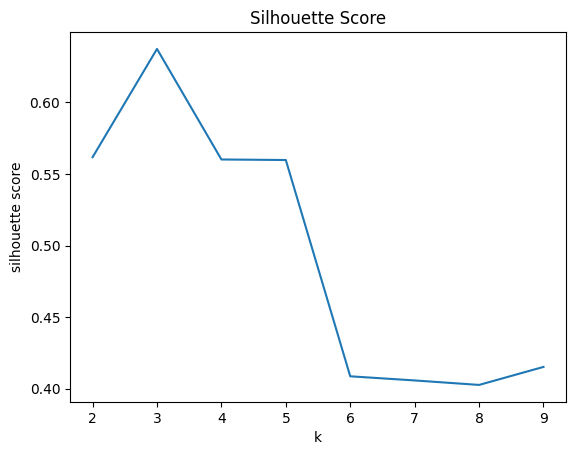

In [ ]:
#Se visualizan los scores del algoritmos para hacer la toma del mejor valor de k
plt.plot(range(2,10),silhouette_score)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.show()

In [51]:
#Se escoge 3 por a media que agregamos las cluster se va perdiendo el score y se van estbailidando en valores alrededor de 0.4
kmeans=KMeans(featuresCol='features_scale', k=3)
pipe = Pipeline(stages=[loan_Status_Idx, assembler, escalador, kmeans])
model=pipe.fit(train_data)
predictions=model.transform(test_data)

In [56]:
# Imprimimos algunos clusters
predictions.select('prediction').show(5)

+----------+
|prediction|
+----------+
|         2|
|         2|
|         2|
|         1|
|         0|
+----------+
only showing top 5 rows



In [ ]:
spark.stop()